Types of changes:

1) Added label for feature

    We need to find the parameters:

        1) image name
        2) bounding box value for the feature
        3) value(Yes, No)

        Pass all the parameters to a function that will:
            a) Crop the original image
            b) Rotate and crop other images

2) Modified label for feature
    Yes, No, Undef => Remove from old, if old = [Yes or No] and add to new if new = [Yes or No]

3) Modified bounding box
    We need to find the parameters:
        1) bounding_box name
        2) model name that corresponds to the bounding box
        3) image_name
        3) feature_name

        Pass all the parameters to a function that will:
            a) Remove old cropped images(original and rotated)
            b) Crop again and add to the model folders for all models that use this bounding box

<!-- 4) Added bounding box
    We need to find the parameters:
        1) bounding_box name
        2) model name that corresponds to the bounding box
        3) image_name
        3) feature_name

        Pass all the parameters to a function that will:
            a) Remove old cropped images(original and rotated)
            b) Crop again and add to the model folders for all models that use this bounding box -->



In [66]:
# BB_TO_FEATURES = {}

# for feature_name, bb_name in FEATURE_TO_BOUNDING_BOX.items():
#     BB_TO_FEATURES[bb_name] = BB_TO_FEATURES.get(bb_name, []) + [feature_name]
# mappings["BB_TO_FEATURES"] = BB_TO_FEATURES

# save_json(mappings, "info.json")

In [10]:
from deepdiff import DeepDiff

diff = DeepDiff(old_decided, decided, ignore_order=True)


In [7]:
unique_features = set()

for r in all_labels:
  unique_features.update(list(r["face_labels"].keys()))

model_to_feature = {}

for f in unique_features:
  u = f.replace("Right", "").replace("Left", "")

  if u not in model_to_feature:
    model_to_feature[u] = [f]
  else:
    model_to_feature[u].append(f)

model_to_feature

NameError: name 'all_labels' is not defined

In [ ]:
from utils.label_validator import ImageLabel

def validate_labels(image_labels):
  return [ImageLabel(**lb) for lb in image_labels]

In [ ]:
all_images = set([l.image_name for l in all_labels])

feature_to_model = {v: k for k, values in model_to_feature.items() for v in values}
feature_to_bb = {f: "_".join(f.split("_")[:-1]) for f in  feature_to_model.keys()}

In [ ]:
from utils.constants import INFO_PATH, IMAGES_PATH

In [ ]:
# with open(INFO_PATH, "w") as f:
#   # data = json.load(f)
#   data = {}
#   data["FEATURE_TO_MODEL"] = feature_to_model
#   data["FEATURE_TO_BOUNDING_BOX"] = feature_to_bb,
#   data["LABELED_IMAGES"] = list(all_images)
#   data["MODELS_TO_FEATURES"] = model_to_feature
#   json.dump(data,f, indent=4)

In [ ]:
# Save data in different folders for different models
# Each object has this format:
# {
#   "image_name": "in_001382_male_21_InGlasses0.jpg",
#   "bounding_box": {
#     "top_left": {
#       "x": 1482,
#       "y": 3654
#     },
#     "bottom_right": {
#       "x": 1864,
#       "y": 3748
#     }
#   }
# }

import os, json
from utils.constants import PROCESSED_LABELS_PATH

original_data = {model_name: {"Yes": {}, "No":{}} for model_name in model_to_feature.keys()}

for label in all_labels:

  for feature, value in label.face_labels.items():
    model_name = feature_to_model[feature]
    if value in ("Yes", "No"):
      bb_name = feature_to_bb[feature]

      side = ""
      if "Left" in feature:
        side = "Left"
      elif "Right" in feature:
        side = "Right"

      bb = label.bounding_boxes.get(bb_name)
      if not bb or bb == "NotValid":
        continue
      img_name = label.image_name
      obj = {
          "image_name": img_name,
          "bounding_box": bb.dict(),
      }
      if side:
        obj["side"] = side
      original_data[model_name][value][img_name] = obj

for model_name, labels in original_data.items():
  
  for label, objects in labels.items():
    
    path = os.path.join(PROCESSED_LABELS_PATH, model_name)
    os.makedirs(path, exist_ok=True)
    
    obj_path = os.path.join(path, f"{label}.json")

    with open(obj_path, "w") as f:
      json.dump(objects, f, indent=4)

In [44]:
from deepdiff import DeepDiff  # For Deep Difference of 2 objects
from deepdiff import grep, DeepSearch  # For finding if item exists in an object
from deepdiff import DeepHash

In [49]:
a = {
    "img1": {
      "l1": "yes", 
      "l2": "no"         
    },
    "goodbye": 2
}

b = {
    "img1": {
      "l1": "no", 
      "l2": "no"         
    },
    "goodbye": 2,
     "bye": 4
}

DeepDiff(a, b)



{'dictionary_item_added': [root['bye']],
 'values_changed': {"root['img1']['l1']": {'new_value': 'no',
   'old_value': 'yes'}}}

In [40]:
import concurrent
from PIL import Image
from utils.constants import CROPPED_RESIZED_PATH, CROPPED_ORIG_PATH
from typing import Tuple, Dict
from tqdm import tqdm
import os
import numpy as np

def read_numpy(src_img_path, size_w_h = Tuple[int, int]):
  return np.array(Image.open(src_img_path))
# Counts the amount of 
def read_images_as_ndarray(model_name: str, size_w_h = Tuple[int, int], max_workers = 100)-> Dict[str, np.ndarray]:
  width, height = size_w_h
  source_model_path = os.path.join(CROPPED_RESIZED_PATH, model_name, f"w_{width}_h_{height}")

  if not os.path.exists(source_model_path):
    raise ValueError(f"Path '{source_model_path}' does not exist")

  data = {}
  for label in ("Yes", "No"):

    source_folder = os.path.join(source_model_path, label)
    images_to_read = [os.path.join(source_folder, img) for img in os.listdir(source_folder) if ".png" in img]
    

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
      futures = []

      for img_path in images_to_read:
        futures.append( executor.submit(read_numpy, img_path))
      data[label] = [future.result() for future in tqdm(concurrent.futures.as_completed(futures))]

  for k in data:
    data[k] = np.array(data[k])
  return data


In [ ]:
model_name = "Eye_OuterCorner_Dark"
data = read_images_as_ndarray(model_name, (125, 200))

In [42]:
import deepdiff

ModuleNotFoundError: ignored

In [39]:
for k, v in data.items():
  print(k, v.shape)

Yes (327, 200, 125, 3)
No (2868, 200, 125, 3)


In [35]:
data["Yes"] = np.array(data["Yes"])

In [36]:
data["Yes"].shape

(327, 200, 125, 3)

In [27]:
model_name = "Eye_OuterCorner_Dark"
resize_images_for_model(model_name, (125, 200))

3195it [00:47, 67.23it/s]


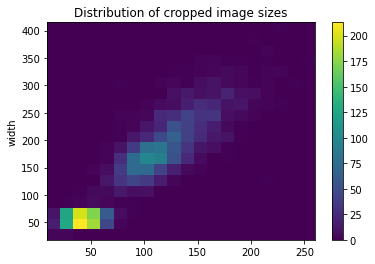

In [ ]:
draw_histogram(widths, heights)

In [ ]:
json_path = "/content/LabelsProcessed/Eye_OuterCorner_Dark/No.json"

with open(json_path) as f:
  objects = json.load(f)

a = [k for k in list(objects.keys())]
print(len(a))

json_path = "/content/LabelsProcessed/Eye_OuterCorner_Dark/Yes.json"

with open(json_path) as f:
  objects = json.load(f)

a = [k for k in list(objects.keys())]
print(len(a))

2889
328


In [41]:
!zip utils.zip utils -r

updating: utils/ (stored 0%)
updating: utils/__pycache__/ (stored 0%)
updating: utils/__pycache__/helper_func.cpython-37.pyc (deflated 41%)
updating: utils/__pycache__/cropping.cpython-37.pyc (deflated 40%)
updating: utils/__pycache__/label_validator.cpython-37.pyc (deflated 54%)
updating: utils/__pycache__/__init__.cpython-37.pyc (deflated 26%)
updating: utils/__pycache__/constants.cpython-37.pyc (deflated 33%)
updating: utils/helper_func.py (deflated 61%)
updating: utils/local_config.json (deflated 26%)
updating: utils/label_validator.py (deflated 72%)
updating: utils/.ipynb_checkpoints/ (stored 0%)
updating: utils/__init__.py (stored 0%)
updating: utils/constants.py (deflated 54%)
updating: utils/cropping.py (deflated 70%)
